# Predictive modeling of edX Learner Attrition

**Problem:** MOOC courses have notoriously high dropout rates and Microsoft courses are no exception. How can we understand dropout trends and do something about them to keep users engaged

**Solution:** Intervene with users before they drop out.

**How?** Predict whether a user in a course will drop out in the next week of the course and engage them with support resources.
* Aggregate user events to understand engagement paterns
* Determine drop out weeks for each user in a course
* Build a model to predict the determined dropout weeks
* Build a cloud service to email "at-risk" users with support resources

## 1 - Packages

In [1]:
import pymssql
import pandas as pd
import numpy as np
from textblob import TextBlob
from datetime import datetime, timedelta
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import cntk as C
from collections import Counter

In [20]:
PREDS = [[-0.00086074],
 [-0.00159799],
 [-0.00169993],
 [-0.04512118],
 [-0.04508126],
 [ 0.51217449]]

In [22]:
preds = np.array(PREDS)
np.round(preds)

array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 1.]])

In [4]:
(preds - preds.min()) / (preds.max() - preds.min())

array([[  7.94200321e-02],
       [  7.80971257e-02],
       [  7.79142067e-02],
       [  0.00000000e+00],
       [  7.16316350e-05],
       [  1.00000000e+00]])

In [6]:
preds.max() - preds.min()

0.55729567000000002

In [6]:
import os

current_course_id = 'Microsoft+DAT206x+4T2017' 

path = 'data'
past_course_ids = [f for f in os.listdir(path) if not f.startswith('.')]
try:
    past_course_ids.remove(current_course_id)
except ValueError:
    print('Not in list')

past_course_ids
test = pd.read_csv('{}/{}/model_data.csv'.format('data', current_course_id))
for course_id in past_course_ids:
    course_data = pd.read_csv('{}/{}/model_data.csv'.format('data', course_id))
    train_test_split(course_data, 0.7)
    

['Microsoft+DAT206x+2T2017',
 'Microsoft+DAT207x+3T2017',
 'Microsoft+DAT207x+1T2017',
 'Microsoft+DAT206x+1T2017',
 'Microsoft+DAT201x+4T2017',
 'Microsoft+DAT222x+4T2017',
 'Microsoft+DAT207x+4T2017',
 'Microsoft+DAT209x+4T2017',
 'Microsoft+DAT201x+3T2017',
 'Microsoft+DAT221x+4T2017',
 'Microsoft+DAT203.2x+4T2017',
 'Microsoft+DAT207x+2T2017',
 'Microsoft+DAT206x+3T2017',
 'Microsoft+DAT203.1x+4T2017']

## 2 - Let's look at a sample from our dataset

In [5]:
feature_names = [ 
    'user_id', 'course_week', 'user_week', 'video_plays',
    'subsections_viewed', 'problems_attempted', 'problems_correct',
    'forum_posts', 'forum_votes_count', 'avg_forum_sentiment'
]

In [11]:
features = pd.DataFrame([
    {
        'user_id': 9999,
        'course_week': 4,
        'user_started_week': 3,
        'num_video_plays': 12.,
        'num_subsections_viewed': 23.,
        'num_problems_attempted': 8.,
        'num_problems_correct': 5.,
        'num_forum_posts': 1.,
        'num_forum_up_votes': 3,
        'avg_forum_sentiment': .72
    },
    {
        'user_id': 100001,
        'course_week': 4,
        'user_started_week': 0,
        'num_video_plays': 0.,
        'num_subsections_viewed': 0.,
        'num_problems_attempted': 0.,
        'num_problems_correct': 0.,
        'num_forum_posts': 0.,
        'num_forum_up_votes': 0,
        'avg_forum_sentiment': .0
    }
])

features[[
    'user_id', 'course_week', 'user_started_week', 'num_video_plays',
    'num_subsections_viewed', 'num_problems_attempted', 'num_problems_correct',
    'num_forum_posts', 'num_forum_up_votes', 'avg_forum_sentiment'
]]

,user_id,course_week,user_started_week,num_video_plays,num_subsections_viewed,num_problems_attempted,num_problems_correct,num_forum_posts,num_forum_up_votes,avg_forum_sentiment
0,9999,4,3,12.0,23.0,8.0,5.0,1.0,3,0.72
1,100001,4,0,0.0,0.0,0.0,0.0,0.0,0,0.00


### Predicted Value (0 or 1): user_dropped_out_next_course_week

# 1. Pull data from SQL Server Staging and Data Warehouse

In [17]:
conn = pymssql.connect(server=wwl_data_warehouse_server, user=user, password=password) 

In [18]:
course_id = 'Microsoft+DAT222x+4T2017' 

In [19]:
events_query = """
SELECT
    Username, UserId, EventType, EventSource, CourseId,
    EventGrade, EventAttempts, EventMaxGrade, EventSub_Correct, EventTime
FROM [EdxStaging].[edx].[Edx_DailyEvents]
WHERE (Host = 'courses.edx.org' and CourseId = '{}')
AND UserId IS NOT NULL
""".format(course_id)

In [20]:
events = pd.read_sql(events_query, conn)

In [21]:
COURSE_DATES_QUERY = """
SELECT TOP(1) [CourseRunStartDate],[CourseRunEndDate]
FROM [EdxDW].[edx].[DimCourse] C
WHERE C.[CourseRunId] = '{}'
""".format(course_id)
course_dates = pd.read_sql(COURSE_DATES_QUERY, conn)
course_start_date = datetime.strptime(course_dates['CourseRunStartDate'][0], '%Y-%m-%d')
course_end_date = datetime.strptime(course_dates['CourseRunEndDate'][0], '%Y-%m-%d')
(course_start_date, course_end_date)

(datetime.datetime(2017, 10, 17, 0, 0), datetime.datetime(2018, 1, 1, 0, 0))

In [22]:
forums_query = """
SELECT [Title]
      ,[CommentText]
      ,[AuthorId]
      ,[AuthorUserName]
      ,[VotesUpCount]
      ,[VotesDownCount]
      ,[VotesCount]
      ,[VotesPoint]              
      ,[CommentCount]      
      ,[ParentId]
      ,[CommentThreadId]
      ,[CourseId]
      ,[TextType]       
      ,[UpdateTimestamp]
  FROM [EdxStaging].[edx].[Edx_Forum]
  WHERE CourseId = '{}'
""".format(course_id)

In [23]:
forums = pd.read_sql(forums_query, conn)

In [24]:
forums.columns=[
    'title', 'comment_text', 'author_id', 'username', 'votes_up', 'votes_down', 
    'votes_count', 'votes_point', 'comment_count', 'parent_id', 'comment_thread_id',
    'course_id', 'text_type', 'update_timestamp'
]
forums.head()

,title,comment_text,author_id,username,votes_up,votes_down,votes_count,votes_point,comment_count,parent_id,comment_thread_id,course_id,text_type,update_timestamp
0,None,Hi myusrn\n\nThe pre-test is used to assess yo...,16524953,JSmith-Lex,0,0,0,0,NaN,59f85002bc04a609f6002b76,59f60ae0bc04a609f0002893,Microsoft+DAT222x+4T2017,Comment,2017-11-03T01:46:11.091Z
1,None,Maybe you should consider changing the questio...,2556761,sjmathis,0,0,0,0,NaN,None,59eeadb04ed74909e8002433,Microsoft+DAT222x+4T2017,Comment,2017-11-03T01:38:15.181Z
2,None,Your pre-test is ridiculous. Why would you mak...,10037972,B212bb,0,0,0,0,NaN,59f05eaebc04a609fc002775,59ef598fbc04a60a2b002557,Microsoft+DAT222x+4T2017,Comment,2017-10-27T02:36:26.510Z
3,None,Welcome to the course. Happy learning!,16524953,JSmith-Lex,0,0,0,0,NaN,None,59f1dbb1bc04a60a2f0027b5,Microsoft+DAT222x+4T2017,Comment,2017-10-27T01:31:45.164Z
4,None,Welcome to the course. Happy learning!,16524953,JSmith-Lex,0,0,0,0,NaN,None,59f2241dbc04a60a07002797,Microsoft+DAT222x+4T2017,Comment,2017-10-27T01:31:21.657Z


In [25]:
course_start_query = """
SELECT U.UserId as user_id
      ,CS.[DateKey] as date_key
  FROM [EdxDW].[edx].[FactCourseStart] CS
  JOIN [EdxDW].[edx].[DimUser] U
  ON CS.UserKey = U.UserKey
  JOIN [EdxDW].[edx].[DimUserPII] PII
  ON PII.UserKey = U.UserKey
  JOIN [EdxDW].[edx].[DimCourse] C
  ON CS.CourseKey = C.CourseKey
  WHERE C.CourseRunId = '{}'
  AND IsBadRow = 0
  ORDER BY DateKey
""".format(course_id)

In [26]:
course_starts = pd.read_sql(course_start_query, conn)

In [27]:
course_starts.head()

,user_id,date_key
0,14868851,20170828
1,6467324,20170905
2,6654643,20170918
3,6675042,20171007
4,8775892,20171010


In [28]:
course_complete_query = """
SELECT U.UserId as user_id
      ,CC.[DateKey] as date_key
  FROM [EdxDW].[edx].[FactCourseCompletion] CC
  JOIN [EdxDW].[edx].[DimUser] U
  ON CC.UserKey = U.UserKey
  JOIN [EdxDW].[edx].[DimUserPII] PII
  ON PII.UserKey = U.UserKey
  JOIN [EdxDW].[edx].[DimCourse] C
  ON CC.CourseKey = C.CourseKey
  WHERE C.CourseRunId = '{}'
  AND IsBadRow = 0
  ORDER BY DateKey
""".format(course_id)

In [29]:
course_completions = pd.read_sql(course_complete_query, conn)

In [64]:
events.columns = [
    'username', 'user_id', 'event_type', 'event_source', 'course_id',
    'event_grade', 'event_attempts', 'event_max_grade', 'event_sub_correct',
    'event_time'
]
events['user_id'] = events['user_id'].astype('int64')
events.head()

,username,user_id,event_type,event_source,course_id,event_grade,event_attempts,event_max_grade,event_sub_correct,event_time
0,CFRandall,5267382,/courses/course-v1:Microsoft+DAT201x+4T2017/xb...,server,Microsoft+DAT201x+4T2017,NaN,NaN,NaN,None,2017-09-07T22:32:44.446885+00:00
1,CFRandall,5267382,/courses/course-v1:Microsoft+DAT201x+4T2017/xb...,server,Microsoft+DAT201x+4T2017,NaN,NaN,NaN,None,2017-09-07T22:32:40.749985+00:00
2,Graeme_Malcolm,6467324,/courses/course-v1:Microsoft+DAT201x+4T2017/xb...,server,Microsoft+DAT201x+4T2017,NaN,NaN,NaN,None,2017-09-07T17:19:29.860471+00:00
3,Graeme_Malcolm,6467324,/courses/course-v1:Microsoft+DAT201x+4T2017/co...,server,Microsoft+DAT201x+4T2017,NaN,NaN,NaN,None,2017-09-07T17:19:13.849931+00:00
4,Graeme_Malcolm,6467324,/courses/course-v1:Microsoft+DAT201x+4T2017/di...,server,Microsoft+DAT201x+4T2017,NaN,NaN,NaN,None,2017-09-07T18:05:04.894596+00:00


# 2. Clean Event Data to expose only the events we care about

In [230]:
# Only include events for users that have "started" the course 
# according to Data Warehouse definitions
events = pd.merge(course_starts, events, how='inner', on='user_id')

In [231]:
# TODO: These dates need to be updated for scaling to multiple courses

LONG_DATE_FORMAT = "%Y-%m-%dT%H:%M:%S"
SHORT_DATE_FORMAT = "%Y%m%d"
course_start_date = datetime.strptime("2017-07-01T00:00:00", LONG_DATE_FORMAT)
course_end_date = datetime.strptime("2017-09-30T23:59:00", LONG_DATE_FORMAT)

In [232]:
def course_week(date):
    """
    Find the course week for the event time
    """
    course_week = math.ceil((date - course_start_date).days / 7)
    if course_week == 0:
        course_week = 1
    return course_week

In [233]:
course_week('2017-07-01T00:00:00')

TypeError: unsupported operand type(s) for -: 'str' and 'datetime.datetime'

In [ ]:
def filter_events(events_df):
    """
    1. Filter events to relevant (event_type)s
    2. Define the course_week of the event based on event_time
    3. Set correct problem attempts to a new event_type to 
       aggregate on.
    """
    
    events_to_capture = [
        'problem_check',
        'play_video',    
        'book'
    ]

    events_sub = events_df.loc[events['event_type'].isin(events_to_capture),:]
    events_sub = events_sub.drop(
        events_sub.loc[(events_sub['event_type'] == 'problem_check') & (events_sub['event_source'] == 'browser'),:].index
    )
    SUBSECTION_VIEWED_MARKER = 'subsection_viewed'

    events_df.loc[events_df['event_type'].str.contains('/courseware/'),'event_type'] = SUBSECTION_VIEWED_MARKER
    subsection_events = events_df.loc[events_df['event_type'] == SUBSECTION_VIEWED_MARKER,:]
    events_sub = events_sub.fillna(0.0)
    events_ = events_sub.append(subsection_events)
    events_ = events_.reset_index(drop=True)
    
    events_['course_week'] = events_['event_time'].apply(
        lambda date_string: course_week(datetime.strptime(date_string[0:19], LONG_DATE_FORMAT))
    )
    events_.loc[events_['event_sub_correct'] == 'true', 'event_type'] = 'problem_check:correct'
    events_ = events_.set_index('user_id')
    
    return events_

In [234]:
events_ = filter_events(events)

In [235]:
print(events_.shape)
events_.head()

(1348132, 11)


,date_key,username,event_type,event_source,course_id,event_grade,event_attempts,event_max_grade,event_sub_correct,event_time,course_week
user_id,,,,,,,,,,,
3734412,20170628,WLitzenberg,play_video,browser,Microsoft+DAT206x+3T2017,0.0,0.0,0.0,0,2017-07-04T04:05:52.049667+00:00,1
3734412,20170628,WLitzenberg,play_video,browser,Microsoft+DAT206x+3T2017,0.0,0.0,0.0,0,2017-07-02T19:58:22.096168+00:00,1
3734412,20170628,WLitzenberg,problem_check:correct,server,Microsoft+DAT206x+3T2017,1.0,1.0,1.0,true,2017-07-01T02:04:42.936831+00:00,1
3734412,20170628,WLitzenberg,problem_check:correct,server,Microsoft+DAT206x+3T2017,1.0,1.0,1.0,true,2017-07-01T22:11:46.342661+00:00,1
3734412,20170628,WLitzenberg,problem_check:correct,server,Microsoft+DAT206x+3T2017,1.0,1.0,1.0,true,2017-07-01T22:10:40.935088+00:00,1


In [236]:
pd.unique(events_['event_type'])

array(['play_video', 'problem_check:correct', 'problem_check',
       'subsection_viewed'], dtype=object)

# 3. Aggregate events and forum posts per (user_id, courseweek)

In [249]:
def build_events_features(events_df):
    """
    Aggregate events to create grouped feature DataFrame
    """
    features = pd.DataFrame(events_df.groupby(['course_week', 'user_id'])['event_type'].value_counts())
    features.columns = ['event_counts']
    features = features.unstack()
    features = features.fillna(0.0)
    
    features = features.reset_index()
    
    return features

In [238]:
def process_forum_data(forums_):
    forums_df = forums_.copy()
    forums_df['course_week'] = forums_df['update_timestamp'].apply(
        lambda x: course_week(datetime.strptime(x[0:19], LONG_DATE_FORMAT))
    )
    forums_df = forums_df[['author_id', 'comment_text', 'votes_count', 'course_week']]

    forums_df['sentiment'] = forums_df['comment_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    return forums_df

In [239]:
def build_forum_features(forums_df):
    forums_ = process_forum_data(forums_df)

    forum_features = forums_.groupby(['course_week', 'author_id'])[['comment_text', 'votes_count', 'sentiment']].agg({
        'comment_text': 'count',
        'votes_count': 'sum',
        'sentiment': 'mean'
    }).reset_index()

    forum_features.columns = ['course_week', 'user_id', 'comment_text', 'votes_count', 'sentiment']
    
    return forum_features

In [250]:
event_features = build_events_features(events_)
event_features.head()

course_week user_id event_counts                \
event_type                       play_video problem_check   
0                    1    9201          1.0           5.0   
1                    1   17198         15.0           6.0   
2                    1   24487         62.0           5.0   
3                    1   28435         13.0           1.0   
4                    1   28963          0.0           0.0   

                                                    
event_type problem_check:correct subsection_viewed  
0                           10.0              10.0  
1                           21.0              23.0  
2                           19.0              15.0  
3                           27.0              15.0  
4                            1.0               7.0

In [252]:
event_features.columns = event_features.columns.get_level_values(0)
features.to_csv()

In [253]:
event_features.head()

,course_week,user_id,event_counts,event_counts,event_counts,event_counts
0,1,9201,1.0,5.0,10.0,10.0
1,1,17198,15.0,6.0,21.0,23.0
2,1,24487,62.0,5.0,19.0,15.0
3,1,28435,13.0,1.0,27.0,15.0
4,1,28963,0.0,0.0,1.0,7.0


In [254]:
forum_features = build_forum_features(forums)
forum_features.head()

,course_week,user_id,comment_text,votes_count,sentiment
0,1,311622,0,0.000000,1
1,1,346516,0,0.243750,2
2,1,679567,0,0.000000,1
3,1,1489478,1,-0.042857,1
4,1,1949018,0,0.171875,2


In [256]:
features = pd.merge(event_features, forum_features, how='left', on=['user_id', 'course_week'])
# features = features.drop(['user_id', 'course_week'], axis=1)
features.columns = [
    'course_week', 
    'user_id', 
    'num_video_plays', 
    'num_problems_incorrect', 
    'num_problems_correct',
    'num_subsections_viewed',
    'num_forum_posts',
    'num_forum_votes',
    'avg_forum_sentiment'
]
features.head()

,course_week,user_id,num_video_plays,num_problems_incorrect,num_problems_correct,num_subsections_viewed,num_forum_posts,num_forum_votes,avg_forum_sentiment
0,1,9201,1.0,5.0,10.0,10.0,NaN,NaN,NaN
1,1,17198,15.0,6.0,21.0,23.0,NaN,NaN,NaN
2,1,24487,62.0,5.0,19.0,15.0,NaN,NaN,NaN
3,1,28435,13.0,1.0,27.0,15.0,NaN,NaN,NaN
4,1,28963,0.0,0.0,1.0,7.0,NaN,NaN,NaN


In [ ]:
features.shape

In [ ]:
features.head()

# 4. Join features with course starts and completions

In [ ]:
def join_data_sources(features_df, course_starts_df, course_completions_df):
    """"""
    data = pd.merge(features_df, course_starts_df, how='inner', on='user_id')
    data.columns = list(data.columns)[0:-1] + ['user_started_date_key']
    data = pd.merge(data, course_completions_df, how='left', on='user_id')
    data.columns = list(data.columns)[0:-1] + ['user_completed_date_key']
    
    def convert_col_to_datetime(column_name):
        data[column_name] = data[column_name].astype(str)
        data.loc[data[column_name] == 'nan', column_name] = '20170620' # fix this to be dynamic date string
        data[column_name] = data[column_name].apply(lambda x: datetime.strptime(x[0:8], '%Y%m%d'))
        return data
    
    data = convert_col_to_datetime('user_started_date_key')
    data = convert_col_to_datetime('user_completed_date_key')
    
    
    data['user_started_week'] = data['user_started_date_key'].apply(course_week)
    data['user_completed_week'] = data['user_completed_date_key'].apply(course_week)
        
    last_active_week = data.sort_values('course_week').groupby('user_id').last()[['course_week']]
    last_active_week.columns = ['user_last_active_week']
    last_active_week = last_active_week.reset_index()
    data = pd.merge(data, last_active_week, how='left', on='user_id')
    
    data['num_problems_attempted'] = data['num_problems_incorrect'] + data['num_problems_correct']
    data = data[[
        'user_id',
        'course_week',
        'num_video_plays',
        'num_problems_attempted',
        'num_problems_correct',
        'num_subsections_viewed',
        'num_forum_posts',
        'num_forum_votes',
        'avg_forum_sentiment',
        'user_started_week',
        'user_last_active_week',
        'user_completed_week'
    ]]
    
    return data

In [ ]:
data = join_data_sources(features, course_starts, course_completions)
data.head(20)

pd.DataFrame()

In [ ]:
data = data.fillna(0.0)

In [ ]:
data.to_csv('all_features_revised_11-18.csv')

In [ ]:
print(data.shape)
data.head()

---

# 5. Calculate user_dropped_out_next_week value for each row

In [259]:
# Restore features file to avoid pipeline
data = pd.read_csv('all_features_revised_11-18.csv')

In [260]:
def add_extra_data_points_for_non_active_weeks(data_df):
    data = data_df.copy()
    for user_id in pd.unique(data['user_id']):
        for week in sorted(pd.unique(data['course_week'])):
            df = data.loc[(data['user_id'] == user_id) & (data['course_week'] == week), :]
            user_info = data.loc[(data['user_id'] == user_id), :]
            started_week = list(user_info['user_started_week'])[0]
            last_active_week = list(user_info['user_last_active_week'])[0]
            if len(df) == 0 and (week <= last_active_week):
                new_zero_row = pd.DataFrame([{
                    'user_id': user_id, 
                    'course_week': week,
                    'user_started_week': started_week,
                    'user_last_active_week': last_active_week,
                    'user_completed_week': list(user_info['user_completed_week'])[0],
                }], columns=data.columns).fillna(0.0)
                data = data.append(new_zero_row)
                data = data.reset_index(drop=True)

    data = data.sort_values(['user_id', 'course_week']).reset_index(drop=True)
    return data

data = add_extra_data_points_for_non_active_weeks(data)

In [261]:
def calculate_drop_out_next_week(data_df):
    data_ = data_df.copy()
    data_['user_dropped_out_next_week'] = np.where(data_['user_last_active_week'] == data_['course_week'], 1, 0)
    data_.loc[data_['user_completed_week'] > -1, 'user_dropped_out_next_week'] = 0
    return data_

data = calculate_drop_out_next_week(data)

In [262]:
data.columns

Index(['Unnamed: 0', 'user_id', 'course_week', 'num_video_plays',
       'num_problems_attempted', 'num_problems_correct',
       'num_subsections_viewed', 'num_forum_posts', 'num_forum_votes',
       'avg_forum_sentiment', 'user_started_week', 'user_last_active_week',
       'user_completed_week', 'user_dropped_out_next_week'],
      dtype='object')

In [263]:
data.shape

(147780, 14)

In [10]:
data = data.drop('Unnamed: 0', axis=1)

In [265]:
data.to_csv('all_features_added_negative_rows.csv')

---

# 6. Train the model to predict user_dropped_out_next_week 

In [4]:
# Continue with all data as of 11/18 (calculated by the first 5 steps of this notebook)
data = pd.read_csv('../edx_learner_attrition/all_data_model_step.csv')

In [11]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    data.drop('user_dropped_out_next_week', axis=1), 
    data[['user_id', 'course_week', 'user_dropped_out_next_week']], 
    test_size=0.4, random_state=42
)

In [12]:
X_cols = [
    'course_week', 'num_video_plays', 'num_problems_attempted',
    'num_problems_correct', 'num_subsections_viewed', 'num_forum_posts',
    'num_forum_votes', 'avg_forum_sentiment', 'user_started_week',
]

X_train = np.array(X_train_df[X_cols])
X_test = np.array(X_test_df[X_cols])

y_train = np.array(y_train_df['user_dropped_out_next_week'])
y_test = np.array(y_test_df['user_dropped_out_next_week'])

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(88668, 9)
(88668,)
(59112, 9)
(59112,)


In [19]:
X_train_df.num_video_plays.describe()
# plt.show()

count    88668.000000
mean         3.794819
std         19.847913
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        866.000000
Name: num_video_plays, dtype: float64

In [21]:
pd.Series(np.log(1 + X_train_df.num_video_plays)).describe()

count    88668.000000
mean         0.418548
std          1.007877
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          6.765039
Name: num_video_plays, dtype: float64

In [22]:
np.log(1 + X_train_df)

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


,user_id,course_week,num_video_plays,num_problems_attempted,num_problems_correct,num_subsections_viewed,num_forum_posts,num_forum_votes,avg_forum_sentiment,user_started_week,user_last_active_week,user_completed_week
107492,16.553661,2.484907,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.791759,2.639057,2.639057
5208,14.329334,1.791759,0.693147,0.000000,0.000000,2.833213,0.0,0.0,0.0,1.791759,1.791759,-inf
29842,15.955475,1.098612,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.197225,2.564949,-inf
3931,13.955509,0.693147,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.197225,2.639057,-inf
75841,16.504076,1.386294,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.791759,2.397895,-inf
93599,16.539533,1.609438,4.644391,4.127134,3.951244,3.663562,0.0,0.0,0.0,1.609438,1.609438,-inf
29325,15.938635,2.564949,2.833213,4.007333,2.995732,3.218876,0.0,0.0,0.0,1.791759,2.564949,-inf
80599,16.519191,2.772589,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.302585,2.890372,-inf
106200,16.552419,1.386294,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.791759,1.791759,-inf
39525,16.158903,1.098612,0.000000,0.000000,0.000000,0.693147,0.0,0.0,0.0,0.693147,2.833213,0.693147


In [270]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## CNTK implementation of network

In [ ]:
# Ensure we always get the same amount of randomness
np.random.seed(0)

# Define the data dimensions
input_dim = 9
num_output_classes = 2
num_hidden_layers = 1
hidden_layers_dim = 8

In [ ]:
input = C.input_variable(input_dim)
label = C.input_variable(num_output_classes)

In [ ]:
def create_model(features):
    with C.layers.default_options(init=C.layers.glorot_uniform(), activation=C.sigmoid):
        h = features
        for _ in range(num_hidden_layers):
            h = C.layers.Dense(hidden_layers_dim)(h)
        last_layer = C.layers.Dense(num_output_classes, activation = None)
        
        return last_layer(h)
        
z = create_model(input)

In [ ]:
loss = C.cross_entropy_with_softmax(z, label)
eval_error = C.classification_error(z, label)
# Instantiate the trainer object to drive the model training
learning_rate = 0.5
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch) 
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, eval_error), [learner])

# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):    
    training_loss = "NA"
    eval_error = "NA"

    if mb % frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        print("Minibatch: {}, Train Loss: {}, Train Error: {}".format(mb, training_loss, eval_error))
        
    return mb, training_loss, eval_error

In [ ]:
# Initialize the parameters for the trainer
minibatch_size = 25
num_samples = len(X_train)
num_minibatches_to_train = num_samples / minibatch_size

In [ ]:
# Run the trainer and perform model training
training_progress_output_freq = 20

plotdata = {"batchsize":[], "loss":[], "error":[]}

for i in range(0, int(num_minibatches_to_train)):
    idx = i * minibatch_size
    features = X_train[idx:idx+minibatch_size]
    labels = [[1, 0] if y == 0 else [0, 1] for y in y_train[idx:idx+minibatch_size]]
    
    # Specify the input variables mapping in the model to actual minibatch data for training
    trainer.train_minibatch({input : features, label : labels})
    batchsize, loss, error = print_training_progress(
        trainer, i, training_progress_output_freq, verbose=0
    )

In [ ]:
features = X_test
labels = [[1, 0] if y == 0 else [0, 1] for y in y_test]
trainer.test_minibatch({input: features, label: labels})

In [ ]:
out = C.softmax(z)
predicted_label_probs = out.eval({input : features})

In [ ]:
predicted_label_probs

In [ ]:
softmax_threshold = Counter(y_test)[1] / (Counter(y_test)[1] + Counter(y_test)[0])

In [ ]:
preds = []

# Calculate preds from softmax with significant bias
# to any prediction with greater than {softmax_threshold} 
# probability (between .1 and .2)
# of positive (user_dropped_out_next_week) prediction.
# This helps to offset the significant data imbalance
# of negative entries.
#
# e.g.
#    softmax_threshold = .13
#    [94, 6] => 0
#    [85, 15] => 1

for row in predicted_label_probs:
    if row[1] > softmax_threshold:
        preds.append(1)
    else:
        preds.append(0)

In [ ]:
labels_maxed = [np.argmax(label) for label in labels]

In [ ]:
# Accuracy score for the model
np.mean(np.array(labels_maxed == np.array(preds)))

In [ ]:
metrics.confusion_matrix(labels_maxed, preds)

In [ ]:
metrics.cohen_kappa_score(features, preds)

In [ ]:
y_test_df['predicted_user_dropped_out_next_week'] = preds

In [ ]:
predicted_data = pd.merge(y_test_df, data, on=['user_id', 'course_week']).sort_values(['user_id', 'course_week'])[[
    'user_id', 'course_week', 'user_dropped_out_next_week_x', 'predicted_user_dropped_out_next_week'
]]

In [ ]:
predicted_data.head()

In [ ]:
predicted_data.pivot_table(
    index='user_id', columns=['course_week'], values='predicted_user_dropped_out_next_week', fill_value=-1
).to_csv('user_journey_predicted_test_data.csv')

In [ ]:
data.pivot_table(
    index='user_id', columns=['course_week'], values='user_dropped_out_next_week', fill_value=-1
).to_csv('user_journey_actual.csv')

In [ ]:
data.to_csv('all_data_model_step.csv')

---

# 7. More experiments to deliver a better algorithm

In [ ]:
# 

In [ ]:


from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier



kfold = model_selection.KFold(n_splits=10, random_state=seed)

cart = CNTKClassifier(input_dim=9, hidden_layers_dim=8, num_hidden_layers=1, num_output_classes=2, learning_rate=0.5)
num_trees = 100
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)

results = model_selection.cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

In [88]:
from sklearn.utils import resample

In [99]:
bootstrap_sample_sizes = [.5, .6, .7, .8]
resample(data, n_samples)

,Unnamed: 0,user_id,course_week,num_video_plays,num_problems_attempted,num_problems_correct,num_subsections_viewed,num_forum_posts,num_forum_votes,avg_forum_sentiment,user_started_week,user_last_active_week,user_completed_week,user_dropped_out_next_week
67071,67071,14059633,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,16,-1,0
106843,106843,15449413,5,0.0,1.0,1.0,5.0,0.0,0.0,0.0,5,7,-1,0
10321,10321,3182606,9,0.0,2.0,0.0,12.0,0.0,0.0,0.0,1,12,10,0
116597,116597,15583373,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,7,-1,0
55267,55267,12673869,1,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1,7,-1,0


In [324]:
data.head()

,Unnamed: 0,user_id,course_week,num_video_plays,num_problems_attempted,num_problems_correct,num_subsections_viewed,num_forum_posts,num_forum_votes,avg_forum_sentiment,user_started_week,user_last_active_week,user_completed_week,user_dropped_out_next_week
0,0,516,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,10,-1,0
1,1,516,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,10,-1,0
2,2,516,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,10,-1,0
3,3,516,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,10,-1,0
4,4,516,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,10,-1,0


In [354]:
data_pima = read_csv('pima-indians-diabetes.data.csv', header=None)
values = data_pima.values
# configure bootstrap
n_iterations = 100

bootstrap_sample_sizes = [.5, .6, .7]

def bootstrap_resample(data, n_iterations=1, boostrap_sample_sizes=[.6, .7, .8]):
#     for size in bootstrap_sample_sizes:
    n_size = .8 # int(len(data) * size)
    X = data
    y = data[['user_id', 'course_week', 'user_dropped_out_next_week']]
    for i in range(n_iterations):
        # prepare train and test sets
        num_samples = int(len(data) * n_size)
        train = resample(np.array(data), n_samples=num_samples)
        test = np.array([x for x in values if x.tolist() not in train.tolist()])
        yield (train, test)
        
            
from collections import Iterable
bootstrap_resample(data)

<generator object bootstrap_resample at 0x7f6636d1bbf8>

In [ ]:
bootstrap_resample(d)

In [358]:
from sklearn.model_selection import BaseCrossValidator
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples

class BootstrapCrossValidator(BaseCrossValidator):
    """
    Bootstrap sampling Cross Validator
    """
    def __init__(self, n_iterations=10, bootstrap_sample_sizes=[.6, .7, .8]):
        self.n_iterations = n_iterations
        self.bootstrap_sample_sizes = bootstrap_sample_sizes
        
    def split(self, X, y=None, groups=None):        
        for train, test in super(BootstrapCrossValidator, self).split(X, y):
            yield train, test
            
    def _iter_test_indices(self, X, y=None, groups=None):
        n_samples = _num_samples(X)
        for size in self.bootstrap_sample_sizes:
            n_size = int(len(X) * size)
            for i in range(self.n_iterations):
                # prepare train and test sets            
                yield np.random.randint(0, n_samples, n_size)
                
    def get_n_splits(self, X, y=None, groups=None):
        """Returns the number of splitting iterations in the cross-validator
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : object
            Always ignored, exists for compatibility.
        groups : object
            Always ignored, exists for compatibility.
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        if X is None:
            raise ValueError("The 'X' parameter should not be None.")
        return _num_samples(X)


In [359]:
for indices in BootstrapCrossValidator()._iter_test_indices(data):
    print(indices)

BootstrapCrossValidator(bootstrap_sample_sizes=[0.6, 0.7, 0.8],
            n_iterations=10)

In [335]:
resample(data)

,Unnamed: 0,user_id,course_week,num_video_plays,num_problems_attempted,num_problems_correct,num_subsections_viewed,num_forum_posts,num_forum_votes,avg_forum_sentiment,user_started_week,user_last_active_week,user_completed_week,user_dropped_out_next_week
131690,131690,15743435,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,11,-1,0
119562,119562,15613591,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,13,12,0
104838,104838,15415897,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4,-1,0
61504,61504,13408482,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,8,8,0
94894,94894,15259570,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,8,-1,0
59351,59351,13129931,5,0.0,0.0,0.0,5.0,0.0,0.0,0.0,7,9,-1,0
53390,53390,12421975,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,17,-1,0
88989,88989,15165000,3,2.0,0.0,0.0,2.0,0.0,0.0,0.0,1,3,-1,1
60777,60777,13305504,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,11,11,0
35714,35714,9649617,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,10,-1,0


In [106]:
from pandas import read_csv
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
# load dataset
data_pima = read_csv('pima-indians-diabetes.data.csv', header=None)
values = data_pima.values
# configure bootstrap
n_iterations = 100

bootstrap_sample_sizes = [.5, .6, .7]

# run bootstrap
stats = list()
for size in bootstrap_sample_sizes:
    n_size = int(len(data_pima) * size)
    for i in range(n_iterations):
        # prepare train and test sets
        train = resample(values, n_samples=n_size)
        test = np.array([x for x in values if x.tolist() not in train.tolist()])
        # fit model
#         model = DecisionTreeClassifier()
#         model.fit(train[:,:-1], train[:,-1])
#         # evaluate model
#         predictions = model.predict(test[:,:-1])
#         score = accuracy_score(test[:,-1], predictions)
#         print(score)
#         stats.append((model, score))

        yield (train, test)

# plot scores
pyplot.hist(stats)
pyplot.show()
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

0.683982683983
0.683544303797
0.671673819742
0.725877192982
0.698481561822
0.701754385965
0.688559322034
0.703056768559
0.693304535637
0.721982758621
0.665966386555
0.704255319149
0.718681318681
0.717062634989
0.696390658174
0.678260869565
0.727659574468
0.658798283262
0.716129032258
0.690831556503
0.679569892473
0.704016913319
0.654736842105
0.670235546039
0.700431034483
0.693654266958
0.685106382979
0.657446808511
0.670235546039
0.734475374732
0.715835140998
0.669491525424
0.679569892473
0.719565217391
0.684647302905
0.664543524416
0.692796610169
0.702127659574
0.681034482759
0.713978494624
0.678879310345
0.7096069869
0.713333333333
0.695652173913
0.701754385965
0.700209643606
0.69392033543
0.674468085106
0.70626349892
0.706638115632
0.6852248394
0.673728813559
0.686847599165
0.686567164179
0.689507494647
0.681720430108
0.662473794549
0.694805194805
0.710583153348
0.726086956522
0.701271186441
0.677631578947
0.663043478261
0.680761099366
0.70715835141
0.663043478261
0.694623655914
0.

TypeError: unorderable types: float() >= DecisionTreeClassifier()

In [105]:
stats[np.argsort(stats)[-1]]

0.75878220140515218

---

In [ ]:
# Integrating with Keras

In [272]:
import keras

In [276]:
X_train.shape

(88668, 9)

In [8]:
X = np.array(data[[
    'course_week', 'num_video_plays', 'num_problems_attempted',
    'num_problems_correct', 'num_subsections_viewed', 'num_forum_posts',
    'num_forum_votes', 'avg_forum_sentiment', 'user_started_week',
]])
Y = np.array(data['user_dropped_out_next_week'])

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(X)

X = scaler.transform(X)

In [41]:
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score

def false_negative_percentage(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)[1][0] / len(y_true)

typeII_err = make_scorer(false_negative_percentage, greater_is_better=False)

In [52]:
import numpy
from sklearn.model_selection import GridSearchCV, cross_val_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam', num_hidden_layers=2, hidden_layers_dim=8):
    # create model
    model = Sequential()
    model.add(Dense(hidden_layers_dim, input_dim=9, activation='relu'))
    for i in range(num_hidden_layers):
        model.add(Dense(hidden_layers_dim, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


model = KerasClassifier(build_fn=create_model, verbose=1)
# model.fit(X, Y, epochs=1, batch_size=20)
# score = model.score(X_test, y_test)
# preds = model.predict(X_test)
# score

num_hidden_layers = [1, 2, 3]
hidden_layers_dim = [4, 6, 8]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
batch_size = [100]
epochs = [1]
param_grid = dict(
    optimizer=optimizer, 
    num_hidden_layers=num_hidden_layers, 
    hidden_layers_dim=hidden_layers_dim,
    batch_size=batch_size,
    epochs=epochs
)
print(param_grid)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'type2_min': typeII_err
}
print(scoring)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, scoring=typeII_err)
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

{'hidden_layers_dim': [4, 6, 8], 'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'], 'epochs': [1], 'batch_size': [10], 'num_hidden_layers': [1, 2, 3]}
{'type2_min': make_scorer(false_negative_percentage, greater_is_better=False), 'accuracy': make_scorer(accuracy_score)}
Epoch 1/1
   60/98520 [..............................] - ETA: 4:54 - loss: 0.6877 - acc: 0.8500

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input34848") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 82s 832us/step
Epoch 1/1
   90/98520 [..............................] - ETA: 3:45 - loss: 0.6771 - acc: 0.8889

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input35269") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 73s 744us/step
Epoch 1/1
   10/98520 [..............................] - ETA: 30:14 - loss: 0.8455 - acc: 0.1000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input35690") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 17s 178us/step
Epoch 1/1
  110/98520 [..............................] - ETA: 2:27 - loss: 0.7233 - acc: 0.2091

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input36111") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 16s 159us/step
Epoch 1/1
  750/98520 [..............................] - ETA: 24s - loss: 0.6621 - acc: 0.8853

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input36712") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 18s 180us/step
Epoch 1/1
  150/98520 [..............................] - ETA: 1:38 - loss: 0.5486 - acc: 0.8467

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input37313") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 18s 182us/step
Epoch 1/1
  740/98520 [..............................] - ETA: 24s - loss: 0.4922 - acc: 0.8635

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input37913") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 204us/step
Epoch 1/1
  230/98520 [..............................] - ETA: 1:21 - loss: 0.6335 - acc: 0.8826

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input38435") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 21s 212us/step
Epoch 1/1
  260/98520 [..............................] - ETA: 1:07 - loss: 0.6688 - acc: 0.7538   

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input38957") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 21s 216us/step
Epoch 1/1
  710/98520 [..............................] - ETA: 26s - loss: 0.6135 - acc: 0.8761

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input39479") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 18s 185us/step
Epoch 1/1
   80/98520 [..............................] - ETA: 3:59 - loss: 0.6908 - acc: 0.9125

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input40295") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 202us/step
Epoch 1/1
  440/98520 [..............................] - ETA: 43s - loss: 0.6028 - acc: 0.8477

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input41111") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 18s 187us/step
Epoch 1/1
  740/98520 [..............................] - ETA: 25s - loss: 0.5925 - acc: 0.8581

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input41929") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 18s 187us/step
Epoch 1/1
  840/98520 [..............................] - ETA: 23s - loss: 0.6680 - acc: 0.7690 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input42720") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 21s 217us/step
Epoch 1/1
   50/98520 [..............................] - ETA: 6:34 - loss: 0.6504 - acc: 0.9200 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input43511") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 19s 198us/step
Epoch 1/1
  840/98520 [..............................] - ETA: 21s - loss: 0.5952 - acc: 0.8095

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input44302") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 68s 691us/step
Epoch 1/1
   60/98520 [..............................] - ETA: 4:08 - loss: 0.6892 - acc: 0.9333

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input45034") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 63s 641us/step
Epoch 1/1
   60/98520 [..............................] - ETA: 5:19 - loss: 0.6867 - acc: 0.6833

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input45766") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 63s 639us/step
Epoch 1/1
   30/98520 [..............................] - ETA: 7:54 - loss: 0.7245 - acc: 0.0667 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input46498") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 65s 655us/step
Epoch 1/1
   40/98520 [..............................] - ETA: 6:30 - loss: 0.6917 - acc: 0.6500     

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input47687") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 63s 636us/step
Epoch 1/1
  100/98520 [..............................] - ETA: 3:13 - loss: 0.6002 - acc: 0.8900

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input48876") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 69s 698us/step
Epoch 1/1


/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input50081") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 52s 528us/step
Epoch 1/1


/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input50591") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 21s 212us/step
Epoch 1/1
  880/98520 [..............................] - ETA: 20s - loss: 0.6066 - acc: 0.8034

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input51101") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 28s 280us/step
Epoch 1/1
   40/98520 [..............................] - ETA: 7:35 - loss: 0.6682 - acc: 0.8750

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input51611") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 21s 213us/step
Epoch 1/1
  170/98520 [..............................] - ETA: 1:36 - loss: 0.6684 - acc: 0.8176

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input52361") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 21s 211us/step
Epoch 1/1
  780/98520 [..............................] - ETA: 24s - loss: 0.6187 - acc: 0.8410

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input53111") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 21s 216us/step
Epoch 1/1
  790/98520 [..............................] - ETA: 22s - loss: 0.6161 - acc: 0.8367

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input53860") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 37s 374us/step
Epoch 1/1
  830/98520 [..............................] - ETA: 21s - loss: 0.5830 - acc: 0.8217 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input54505") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 39s 395us/step
Epoch 1/1
   60/98520 [..............................] - ETA: 4:34 - loss: 0.6853 - acc: 0.7000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input55150") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 207us/step
Epoch 1/1
   90/98520 [..............................] - ETA: 3:13 - loss: 0.7279 - acc: 0.1444

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input55795") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 23s 234us/step
Epoch 1/1
   80/98520 [..............................] - ETA: 3:35 - loss: 0.7086 - acc: 0.2250

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input56832") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 21s 218us/step
Epoch 1/1
  100/98520 [..............................] - ETA: 2:51 - loss: 0.6925 - acc: 0.6400

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input57869") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 23s 229us/step
Epoch 1/1
  450/98520 [..............................] - ETA: 35s - loss: 0.5810 - acc: 0.8667

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input58908") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 206us/step
Epoch 1/1
  560/98520 [..............................] - ETA: 34s - loss: 0.6072 - acc: 0.8714 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input59898") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 23s 229us/step
Epoch 1/1
   40/98520 [..............................] - ETA: 7:09 - loss: 0.6962 - acc: 0.2250 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input60888") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 21s 209us/step
Epoch 1/1
  750/98520 [..............................] - ETA: 25s - loss: 0.7122 - acc: 0.5120 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input61878") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 92s 930us/step
Epoch 1/1
   10/98520 [..............................] - ETA: 18:14 - loss: 0.6895 - acc: 0.8000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input62795") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 24s 240us/step
Epoch 1/1
   70/98520 [..............................] - ETA: 4:15 - loss: 0.6896 - acc: 0.8286 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input63712") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 22s 228us/step
Epoch 1/1
  270/98520 [..............................] - ETA: 1:13 - loss: 0.5628 - acc: 0.8630

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input64629") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 26s 263us/step
Epoch 1/1
   90/98520 [..............................] - ETA: 3:39 - loss: 0.7048 - acc: 0.2556

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input66137") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 36s 361us/step
Epoch 1/1
  100/98520 [..............................] - ETA: 3:07 - loss: 0.6391 - acc: 0.8700

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input67645") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 100s 1ms/step
Epoch 1/1
   40/98520 [..............................] - ETA: 6:23 - loss: 0.6492 - acc: 0.9500 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input69169") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 119s 1ms/step
Epoch 1/1
   70/98520 [..............................] - ETA: 4:43 - loss: 0.5227 - acc: 0.9143

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input69768") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 94s 951us/step
Epoch 1/1
  150/98520 [..............................] - ETA: 2:08 - loss: 0.6764 - acc: 0.8200

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input70367") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 101s 1ms/step
Epoch 1/1
   60/98520 [..............................] - ETA: 5:22 - loss: 0.6849 - acc: 0.8500

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input70966") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 95s 969us/step
Epoch 1/1
   30/98520 [..............................] - ETA: 18:49 - loss: 0.6842 - acc: 0.90 - ETA: 10:48 - loss: 0.6767 - acc: 0.8667

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input71865") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 93s 946us/step
Epoch 1/1
   10/98520 [..............................] - ETA: 15:30 - loss: 0.6906 - acc: 0.7000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input72764") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 100s 1ms/step
Epoch 1/1
   50/98520 [..............................] - ETA: 3:43 - loss: 0.6683 - acc: 0.7800

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input73662") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 104s 1ms/step
Epoch 1/1
   20/98520 [..............................] - ETA: 13:04 - loss: 0.6881 - acc: 0.7500

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input74430") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 22s 225us/step
Epoch 1/1
   30/98520 [..............................] - ETA: 10:30 - loss: 0.6829 - acc: 0.8000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input75198") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 22s 220us/step
Epoch 1/1
  110/98520 [..............................] - ETA: 2:27 - loss: 0.6419 - acc: 0.8182

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input75966") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 72s 731us/step
Epoch 1/1
  210/98520 [..............................] - ETA: 1:16 - loss: 0.6156 - acc: 0.8905

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input77224") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 81s 825us/step
Epoch 1/1
   50/98520 [..............................] - ETA: 5:14 - loss: 0.6560 - acc: 0.9200 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input78482") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 27s 272us/step
Epoch 1/1
   80/98520 [..............................] - ETA: 3:28 - loss: 0.6846 - acc: 0.7625

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input79742") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 23s 233us/step
Epoch 1/1
  230/98520 [..............................] - ETA: 1:07 - loss: 0.6845 - acc: 0.8957 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input80931") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 26s 260us/step
Epoch 1/1
  390/98520 [..............................] - ETA: 39s - loss: 0.6810 - acc: 0.7359 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input82120") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 25s 256us/step
Epoch 1/1
  120/98520 [..............................] - ETA: 2:41 - loss: 0.6344 - acc: 0.9000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input83309") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 208s 2ms/step
Epoch 1/1
   20/98520 [..............................] - ETA: 14:43 - loss: 0.7102 - acc: 0.0500

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input84411") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 191s 2ms/step
Epoch 1/1


/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input85513") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 192s 2ms/step
Epoch 1/1


/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input86615") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 195s 2ms/step
Epoch 1/1


/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input88442") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 191s 2ms/step
Epoch 1/1
   10/98520 [..............................] - ETA: 29:59 - loss: 0.6120 - acc: 0.7000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input90269") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 186s 2ms/step
Epoch 1/1
   40/98520 [..............................] - ETA: 7:57 - loss: 0.6903 - acc: 0.8250 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input92061") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 120s 1ms/step
Epoch 1/1
   10/98520 [..............................] - ETA: 27:45 - loss: 0.7216 - acc: 0.2000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input92482") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 125s 1ms/step
Epoch 1/1
   90/98520 [..............................] - ETA: 2:51 - loss: 0.6090 - acc: 0.8556

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input92903") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 122s 1ms/step
Epoch 1/1
   60/98520 [..............................] - ETA: 5:16 - loss: 0.6606 - acc: 0.9333

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input93324") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 123s 1ms/step
Epoch 1/1
   50/98520 [..............................] - ETA: 6:56 - loss: 0.5363 - acc: 0.8800

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input93925") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 123s 1ms/step
Epoch 1/1


/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input94526") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 115s 1ms/step
Epoch 1/1
   50/98520 [..............................] - ETA: 6:33 - loss: 0.6840 - acc: 0.6000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input95126") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 119s 1ms/step
Epoch 1/1
   70/98520 [..............................] - ETA: 3:11 - loss: 0.6599 - acc: 0.8571

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input95648") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 126s 1ms/step
Epoch 1/1
   10/98520 [..............................] - ETA: 32:46 - loss: 0.7085 - acc: 0.4000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input96170") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 118s 1ms/step
Epoch 1/1


/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input96692") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 118s 1ms/step
Epoch 1/1
   30/98520 [..............................] - ETA: 9:54 - loss: 0.6770 - acc: 0.7333 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input97508") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 122s 1ms/step
Epoch 1/1
   20/98520 [..............................] - ETA: 15:57 - loss: 0.7683 - acc: 0.1000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input98324") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 123s 1ms/step
Epoch 1/1
   70/98520 [..............................] - ETA: 4:44 - loss: 0.5704 - acc: 0.9000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input99142") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 125s 1ms/step
Epoch 1/1
   30/98520 [..............................] - ETA: 7:56 - loss: 0.5807 - acc: 0.9667 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input99933") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 125s 1ms/step
Epoch 1/1
   70/98520 [..............................] - ETA: 4:29 - loss: 0.7933 - acc: 0.0714

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input100724") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 119s 1ms/step
Epoch 1/1
   50/98520 [..............................] - ETA: 4:28 - loss: 0.6535 - acc: 0.9200 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input101515") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 125s 1ms/step
Epoch 1/1
   30/98520 [..............................] - ETA: 9:20 - loss: 0.7017 - acc: 0.3667 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input102247") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 111s 1ms/step
Epoch 1/1


/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input102979") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 120s 1ms/step
Epoch 1/1


/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input103711") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 126s 1ms/step
Epoch 1/1


/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input104900") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 120s 1ms/step
Epoch 1/1


/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input106089") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 125s 1ms/step
Epoch 1/1
   70/98520 [..............................] - ETA: 4:32 - loss: 0.8534 - acc: 0.2143

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input107294") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 159s 2ms/step
Epoch 1/1
   60/98520 [..............................] - ETA: 5:06 - loss: 0.6812 - acc: 0.6833

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input107804") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 158s 2ms/step
Epoch 1/1
  110/98520 [..............................] - ETA: 2:26 - loss: 0.6493 - acc: 0.7909

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input108314") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 163s 2ms/step
Epoch 1/1
   30/98520 [..............................] - ETA: 9:35 - loss: 0.6782 - acc: 0.9333 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input108824") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 154s 2ms/step
Epoch 1/1
   40/98520 [..............................] - ETA: 7:28 - loss: 0.8396 - acc: 0.1000 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input109574") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 161s 2ms/step
Epoch 1/1
   40/98520 [..............................] - ETA: 5:54 - loss: 0.7007 - acc: 0.3250 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input110324") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 156s 2ms/step
Epoch 1/1
   30/98520 [..............................] - ETA: 8:32 - loss: 0.6626 - acc: 0.8000 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input111073") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 151s 2ms/step
Epoch 1/1
   30/98520 [..............................] - ETA: 7:54 - loss: 0.6612 - acc: 0.7333 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input111718") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 158s 2ms/step
Epoch 1/1
   40/98520 [..............................] - ETA: 5:09 - loss: 0.6172 - acc: 0.8000 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input112363") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 162s 2ms/step
Epoch 1/1
   30/98520 [..............................] - ETA: 10:47 - loss: 0.6088 - acc: 0.8667

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input113008") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 151s 2ms/step
Epoch 1/1
   40/98520 [..............................] - ETA: 5:53 - loss: 0.6313 - acc: 0.8250 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input114045") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 150s 2ms/step
Epoch 1/1
   30/98520 [..............................] - ETA: 7:46 - loss: 0.6657 - acc: 0.8000 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input115082") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 146s 1ms/step
Epoch 1/1
   40/98520 [..............................] - ETA: 7:21 - loss: 0.6493 - acc: 0.8750 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input116121") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 144s 1ms/step
Epoch 1/1
   70/98520 [..............................] - ETA: 4:42 - loss: 0.7297 - acc: 0.1429

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input117111") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 159s 2ms/step
Epoch 1/1
   30/98520 [..............................] - ETA: 10:26 - loss: 0.6836 - acc: 0.8667

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input118101") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 154s 2ms/step
Epoch 1/1
   80/98520 [..............................] - ETA: 4:08 - loss: 0.6994 - acc: 0.2875

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input119091") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 155s 2ms/step
Epoch 1/1
   10/98520 [..............................] - ETA: 26:41 - loss: 0.6867 - acc: 0.7000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input120008") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 158s 2ms/step
Epoch 1/1
   20/98520 [..............................] - ETA: 14:47 - loss: 0.7098 - acc: 0.4500

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input120925") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 149s 2ms/step
Epoch 1/1
   10/98520 [..............................] - ETA: 17:42 - loss: 0.6570 - acc: 0.9000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input121842") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 154s 2ms/step
Epoch 1/1


/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input123350") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 156s 2ms/step
Epoch 1/1
   10/98520 [..............................] - ETA: 29:27 - loss: 0.6637 - acc: 0.9000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input124858") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 156s 2ms/step
Epoch 1/1
   40/98520 [..............................] - ETA: 6:55 - loss: 0.7051 - acc: 0.2500 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input126382") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 201s 2ms/step
Epoch 1/1
   20/98520 [..............................] - ETA: 14:37 - loss: 0.6812 - acc: 0.8500

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input126981") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 197s 2ms/step
Epoch 1/1
   50/98520 [..............................] - ETA: 5:14 - loss: 0.6594 - acc: 0.8400

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input127580") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 194s 2ms/step
Epoch 1/1


/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input128179") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 173s 2ms/step
Epoch 1/1


/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input129078") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 196s 2ms/step
Epoch 1/1


/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input129977") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 186s 2ms/step
Epoch 1/1
   10/98520 [..............................] - ETA: 23:00 - loss: 0.7012 - acc: 0.1000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input130875") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 21s 209us/step
Epoch 1/1
  820/98520 [..............................] - ETA: 21s - loss: 0.4564 - acc: 0.8720

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input131643") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 202us/step
Epoch 1/1
  290/98520 [..............................] - ETA: 57s - loss: 0.5841 - acc: 0.8414

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input132411") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 21s 214us/step
Epoch 1/1
   10/98520 [..............................] - ETA: 16:48 - loss: 0.6988 - acc: 0.2000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input133179") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 17s 173us/step
Epoch 1/1
   10/98520 [..............................] - ETA: 23:27 - loss: 0.8124 - acc: 0.1000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input134437") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 21s 209us/step
Epoch 1/1
  100/98520 [..............................] - ETA: 3:02 - loss: 0.6576 - acc: 0.8400

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input135695") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 205us/step
Epoch 1/1
  440/98520 [..............................] - ETA: 36s - loss: 0.6510 - acc: 0.9000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input136955") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 21s 213us/step
Epoch 1/1
  480/98520 [..............................] - ETA: 31s - loss: 0.6745 - acc: 0.7479

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input138144") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 207us/step
Epoch 1/1
  130/98520 [..............................] - ETA: 2:17 - loss: 0.6921 - acc: 0.5462

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input139333") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 207us/step
Epoch 1/1
  340/98520 [..............................] - ETA: 56s - loss: 0.6731 - acc: 0.8235

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input140522") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 19s 197us/step
Epoch 1/1
  100/98520 [..............................] - ETA: 2:44 - loss: 0.6537 - acc: 0.9200

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input141624") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 207us/step
Epoch 1/1
  480/98520 [..............................] - ETA: 31s - loss: 0.6668 - acc: 0.8375

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input142726") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 204us/step
Epoch 1/1
  420/98520 [..............................] - ETA: 42s - loss: 0.5235 - acc: 0.8905 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input143828") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 21s 210us/step
Epoch 1/1
  220/98520 [..............................] - ETA: 1:27 - loss: 0.6362 - acc: 0.8455

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input145655") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 207us/step
Epoch 1/1
  390/98520 [..............................] - ETA: 45s - loss: 0.6362 - acc: 0.7615     

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input147482") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 19s 195us/step
Epoch 1/1
   80/98520 [..............................] - ETA: 3:28 - loss: 0.6532 - acc: 0.8875

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input149274") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 16s 162us/step
Epoch 1/1
  160/98520 [..............................] - ETA: 1:36 - loss: 0.5992 - acc: 0.8688

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input149695") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 15s 152us/step
Epoch 1/1
  240/98520 [..............................] - ETA: 1:21 - loss: 0.7524 - acc: 0.4500

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input150116") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 18s 178us/step
Epoch 1/1
  220/98520 [..............................] - ETA: 1:26 - loss: 0.6252 - acc: 0.8909

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input150537") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 15s 153us/step
Epoch 1/1
  930/98520 [..............................] - ETA: 18s - loss: 0.4459 - acc: 0.8914

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input151138") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 15s 151us/step
Epoch 1/1
  570/98520 [..............................] - ETA: 35s - loss: 0.6446 - acc: 0.6474 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input151739") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 15s 157us/step
Epoch 1/1
  900/98520 [..............................] - ETA: 18s - loss: 0.4320 - acc: 0.8622

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input152339") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 16s 163us/step
Epoch 1/1
  510/98520 [..............................] - ETA: 31s - loss: 0.5832 - acc: 0.8490 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input152861") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 17s 173us/step
Epoch 1/1
  440/98520 [..............................] - ETA: 43s - loss: 0.5044 - acc: 0.8136

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input153383") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 15s 147us/step
Epoch 1/1
  270/98520 [..............................] - ETA: 1:02 - loss: 0.6389 - acc: 0.7778

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input153905") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 15s 148us/step
Epoch 1/1
  750/98520 [..............................] - ETA: 24s - loss: 0.6173 - acc: 0.8747

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input154721") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 15s 148us/step
Epoch 1/1
  310/98520 [..............................] - ETA: 57s - loss: 0.6365 - acc: 0.8290

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input155537") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 15s 153us/step
Epoch 1/1
  140/98520 [..............................] - ETA: 1:53 - loss: 0.6345 - acc: 0.8071

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input156355") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 15s 157us/step
Epoch 1/1
  870/98520 [..............................] - ETA: 20s - loss: 0.4661 - acc: 0.8747

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input157146") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 17s 173us/step
Epoch 1/1
  140/98520 [..............................] - ETA: 1:47 - loss: 0.6763 - acc: 0.6143

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input157937") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 15s 154us/step
Epoch 1/1


/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input158728") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 17s 168us/step
Epoch 1/1


/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input159460") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 18s 186us/step
Epoch 1/1
  390/98520 [..............................] - ETA: 48s - loss: 0.6299 - acc: 0.7308 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input160192") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 14s 146us/step
Epoch 1/1
  610/98520 [..............................] - ETA: 32s - loss: 0.5413 - acc: 0.7656

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input160924") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 19s 190us/step
Epoch 1/1
  440/98520 [..............................] - ETA: 35s - loss: 0.5312 - acc: 0.8750

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input162113") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 15s 149us/step
Epoch 1/1
   80/98520 [..............................] - ETA: 3:29 - loss: 0.5985 - acc: 0.8750

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input163302") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 19s 196us/step
Epoch 1/1
  360/98520 [..............................] - ETA: 35s - loss: 0.6328 - acc: 0.7806 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input164507") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 19s 198us/step
Epoch 1/1
  640/98520 [..............................] - ETA: 28s - loss: 0.5668 - acc: 0.8656

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input165017") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 15s 157us/step
Epoch 1/1
   20/98520 [..............................] - ETA: 16:00 - loss: 0.6829 - acc: 0.8000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input165527") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 19s 195us/step
Epoch 1/1
  540/98520 [..............................] - ETA: 35s - loss: 0.6485 - acc: 0.8444

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input166037") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 15s 151us/step
Epoch 1/1
  520/98520 [..............................] - ETA: 26s - loss: 0.5249 - acc: 0.8673

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input166787") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 203us/step
Epoch 1/1
  770/98520 [..............................] - ETA: 23s - loss: 0.6528 - acc: 0.7844

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input167537") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 15s 157us/step
Epoch 1/1
   10/98520 [..............................] - ETA: 30:54 - loss: 0.6921 - acc: 0.4000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input168286") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 199us/step
Epoch 1/1
  670/98520 [..............................] - ETA: 27s - loss: 0.5898 - acc: 0.8254

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input168931") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 205us/step
Epoch 1/1
  790/98520 [..............................] - ETA: 22s - loss: 0.3882 - acc: 0.8696

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input169576") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 16s 158us/step
Epoch 1/1
  480/98520 [..............................] - ETA: 30s - loss: 0.6422 - acc: 0.8625

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input170221") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 15s 155us/step
Epoch 1/1
  780/98520 [..............................] - ETA: 24s - loss: 0.6040 - acc: 0.8782

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input171258") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 205us/step
Epoch 1/1
  720/98520 [..............................] - ETA: 27s - loss: 0.5570 - acc: 0.8556

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input172295") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 15s 154us/step
Epoch 1/1
   60/98520 [..............................] - ETA: 5:18 - loss: 0.8578 - acc: 0.1333 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input173334") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 15s 149us/step
Epoch 1/1
  180/98520 [..............................] - ETA: 1:44 - loss: 0.6931 - acc: 0.5722    

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input174324") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 19s 191us/step
Epoch 1/1
  410/98520 [..............................] - ETA: 39s - loss: 0.6485 - acc: 0.8000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input175314") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 207us/step
Epoch 1/1
  810/98520 [..............................] - ETA: 23s - loss: 0.6319 - acc: 0.7914

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input176304") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 21s 209us/step
Epoch 1/1
  140/98520 [..............................] - ETA: 2:04 - loss: 0.7193 - acc: 0.3571

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input177221") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 19s 197us/step
Epoch 1/1
  360/98520 [..............................] - ETA: 42s - loss: 0.6618 - acc: 0.7444

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input178138") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 203us/step
Epoch 1/1
  460/98520 [..............................] - ETA: 35s - loss: 0.6792 - acc: 0.6304

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input179055") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 19s 193us/step
Epoch 1/1
   60/98520 [..............................] - ETA: 4:33 - loss: 0.6577 - acc: 0.8833 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input180563") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 17s 168us/step
Epoch 1/1
   30/98520 [..............................] - ETA: 8:28 - loss: 0.6639 - acc: 0.8000 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input182071") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 199us/step
Epoch 1/1
  590/98520 [..............................] - ETA: 31s - loss: 0.6104 - acc: 0.8814

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input183595") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 204us/step
Epoch 1/1
  620/98520 [..............................] - ETA: 28s - loss: 0.5833 - acc: 0.8726

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input184194") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 202us/step
Epoch 1/1
  840/98520 [..............................] - ETA: 23s - loss: 0.5479 - acc: 0.8571

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input184793") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 17s 176us/step
Epoch 1/1
   90/98520 [..............................] - ETA: 2:55 - loss: 0.6589 - acc: 0.7889

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input185392") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 17s 173us/step
Epoch 1/1
   80/98520 [..............................] - ETA: 4:10 - loss: 0.6716 - acc: 0.8875

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input186291") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 21s 215us/step
Epoch 1/1
   10/98520 [..............................] - ETA: 12:18 - loss: 0.7214 - acc: 0.0000e+00

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input187190") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 206us/step
Epoch 1/1
  580/98520 [..............................] - ETA: 30s - loss: 0.6024 - acc: 0.8569

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input188088") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 16s 164us/step
Epoch 1/1
  190/98520 [..............................] - ETA: 1:29 - loss: 0.6645 - acc: 0.7526

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input188856") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 17s 177us/step
Epoch 1/1
  100/98520 [..............................] - ETA: 3:11 - loss: 0.6369 - acc: 0.7500    

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input189624") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 21s 216us/step
Epoch 1/1
  300/98520 [..............................] - ETA: 52s - loss: 0.7232 - acc: 0.2733

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input190392") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 23s 237us/step
Epoch 1/1
   70/98520 [..............................] - ETA: 4:27 - loss: 0.6814 - acc: 0.8857

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input191650") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 19s 190us/step
Epoch 1/1
   40/98520 [..............................] - ETA: 6:25 - loss: 0.6540 - acc: 0.8250 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input192908") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 205us/step
Epoch 1/1
  420/98520 [..............................] - ETA: 39s - loss: 0.6818 - acc: 0.7262 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input194168") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 18s 187us/step
Epoch 1/1
   40/98520 [..............................] - ETA: 5:37 - loss: 0.6933 - acc: 0.6250 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input195357") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 18s 186us/step
Epoch 1/1
   10/98520 [..............................] - ETA: 14:11 - loss: 0.6895 - acc: 0.9000

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input196546") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 17s 173us/step
Epoch 1/1
   90/98520 [..............................] - ETA: 3:23 - loss: 0.6018 - acc: 0.8778 

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input197735") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 21s 209us/step
Epoch 1/1
  710/98520 [..............................] - ETA: 26s - loss: 0.5044 - acc: 0.8676

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input198837") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 206us/step
Epoch 1/1
  680/98520 [..............................] - ETA: 29s - loss: 0.6218 - acc: 0.8044

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input199939") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 20s 202us/step
Epoch 1/1
   90/98520 [..............................] - ETA: 3:37 - loss: 0.6099 - acc: 0.9111

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input201041") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 22s 218us/step
Epoch 1/1
  300/98520 [..............................] - ETA: 1:01 - loss: 0.6464 - acc: 0.8733

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input202868") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 24s 243us/step
Epoch 1/1
  300/98520 [..............................] - ETA: 1:06 - loss: 0.6549 - acc: 0.7300

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input204695") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


98520/98520 [==============================] - 21s 212us/step
Epoch 1/1
   330/147780 [..............................] - ETA: 1:21 - loss: 0.6105 - acc: 0.8455

/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input206522") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


147780/147780 [==============================] - 134s 904us/step - loss: 0.2130 - acc: 0.9033
Best: -0.038747 using {'hidden_layers_dim': 8, 'optimizer': 'Nadam', 'epochs': 1, 'batch_size': 10, 'num_hidden_layers': 3}
-0.131919 (0.015349) with: {'hidden_layers_dim': 4, 'optimizer': 'SGD', 'epochs': 1, 'batch_size': 10, 'num_hidden_layers': 1}
-0.105224 (0.032741) with: {'hidden_layers_dim': 4, 'optimizer': 'RMSprop', 'epochs': 1, 'batch_size': 10, 'num_hidden_layers': 1}
-0.131933 (0.015364) with: {'hidden_layers_dim': 4, 'optimizer': 'Adagrad', 'epochs': 1, 'batch_size': 10, 'num_hidden_layers': 1}
-0.131933 (0.015364) with: {'hidden_layers_dim': 4, 'optimizer': 'Adadelta', 'epochs': 1, 'batch_size': 10, 'num_hidden_layers': 1}
-0.117046 (0.034795) with: {'hidden_layers_dim': 4, 'optimizer': 'Adam', 'epochs': 1, 'batch_size': 10, 'num_hidden_layers': 1}
-0.131933 (0.015364) with: {'hidden_layers_dim': 4, 'optimizer': 'Adamax', 'epochs': 1, 'batch_size': 10, 'num_hidden_layers': 1}
-0.

In [54]:
grid_result.best_params_

{'batch_size': 10,
 'epochs': 1,
 'hidden_layers_dim': 8,
 'num_hidden_layers': 3,
 'optimizer': 'Nadam'}

In [28]:
X = X.astype(numpy.float32)
X

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.42857143,  0.75      ],
       [ 0.05263158,  0.        ,  0.        , ...,  0.        ,
         0.42857143,  0.75      ],
       [ 0.10526316,  0.        ,  0.        , ...,  0.        ,
         0.42857143,  0.75      ],
       ..., 
       [ 0.47368422,  0.        ,  0.        , ...,  0.        ,
         0.42857143,  0.91666669],
       [ 0.52631581,  0.        ,  0.        , ...,  0.        ,
         0.42857143,  0.91666669],
       [ 0.57894737,  0.00104493,  0.        , ...,  0.        ,
         0.42857143,  0.91666669]], dtype=float32)

In [29]:
Y = Y.astype(numpy.float32)
Y

array([ 0.,  0.,  0., ...,  0.,  0.,  1.], dtype=float32)

In [30]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

bagg = BaggingClassifier(model)
results = cross_val_score(bagg, X, Y)
results

Epoch 1/1


/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input31716") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


Epoch 1/1


/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input31716") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


94848/98520 [===========================>..] - ETA: 9s - loss: 0.3058 - acc: 0.8722Epoch 1/1


/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input32685") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


 4256/98520 [>.............................] - ETA: 3:51 - loss: 0.5469 - acc: 0.8597Epoch 1/1


/home/kabirkhan/Documents/ML_Experiments/py35/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input32685") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


39904/98520 [===========>..................] - ETA: 3:11 - loss: 0.3486 - acc: 0.8668

KeyboardInterrupt: 

In [311]:
preds

array([0, 1, 0, ..., 0, 1, 0])

In [312]:
y_test

array([0, 0, 0, ..., 0, 1, 0])

In [314]:
metrics.confusion_matrix(y_test, preds) / len(y_test)

array([[ 0.82201583,  0.04880566],
       [ 0.03359724,  0.09558127]])

In [ ]:
metrics.confusion_matrix()

In [138]:
bootstrap_resample(dataset)

[(array([[  0.00000000e+00,   1.05000000e+02,   8.40000000e+01, ...,
            7.41000000e-01,   6.20000000e+01,   1.00000000e+00],
         [  2.00000000e+00,   1.22000000e+02,   6.00000000e+01, ...,
            7.17000000e-01,   2.20000000e+01,   0.00000000e+00],
         [  8.00000000e+00,   1.33000000e+02,   7.20000000e+01, ...,
            2.70000000e-01,   3.90000000e+01,   1.00000000e+00],
         ..., 
         [  1.00000000e+00,   8.70000000e+01,   7.80000000e+01, ...,
            1.01000000e-01,   2.20000000e+01,   0.00000000e+00],
         [  5.00000000e+00,   7.70000000e+01,   8.20000000e+01, ...,
            1.56000000e-01,   3.50000000e+01,   0.00000000e+00],
         [  0.00000000e+00,   1.46000000e+02,   8.20000000e+01, ...,
            1.78100000e+00,   4.40000000e+01,   0.00000000e+00]]),
  array([[   6.   ,  148.   ,   72.   , ...,    0.627,   50.   ,    1.   ],
         [   1.   ,   85.   ,   66.   , ...,    0.351,   31.   ,    0.   ],
         [   8.   ,  183.  

# 8. Scale to all Microsoft courses on edx.org and openedx.microsoft.com

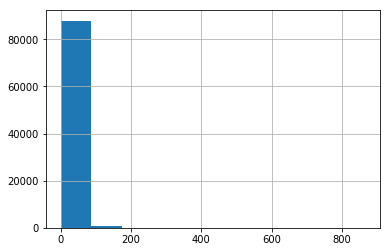

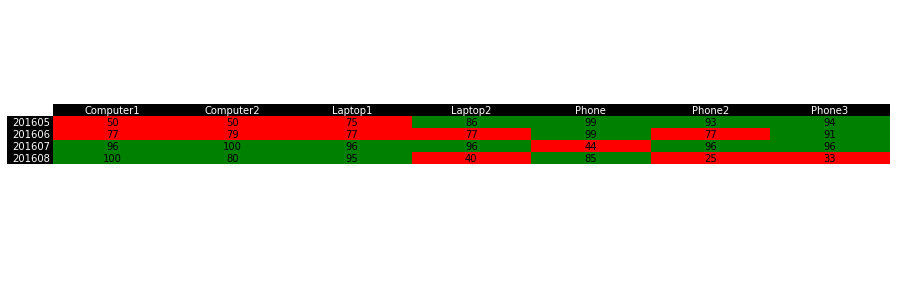

In [17]:
import matplotlib.pyplot as plt
from pandas.plotting import table

#My dataframe
df = pd.DataFrame({
    'Weeks' : [201605, 201606, 201607, 201608],
    'Computer1' : [50, 77, 96, 100],
    'Computer2' : [50, 79, 100, 80],
    'Laptop1'   : [75, 77, 96, 95],
    'Laptop2'   : [86, 77, 96, 40],
    'Phone'     : [99, 99, 44, 85],
    'Phone2'    : [93, 77, 96, 25],
    'Phone3'    : [94, 91, 96, 33]
})
df2 = df.set_index('Weeks') #Makes the column 'Weeks' the index.

colors = df2.applymap(lambda x: 'green' if x>= 80 else 'red') \
        .reset_index().drop(['Weeks'], axis=1)

#print(colors)

plt.figure(figsize=(15,10))

ax = plt.subplot(2, 1, 1, frame_on=True) # no visible frame

#ax.xaxis.set_visible(False)    # hide the x axis
#ax.yaxis.set_visible(False)    # hide the y axis

# hide all axises
ax.axis('off')

# http://matplotlib.org/api/pyplot_api.html?highlight=table#matplotlib.pyplot.table
tbl = table(ax, df2,
            loc='center',
            cellLoc='center',
            cellColours=colors.as_matrix(),
            colColours=['black']*len(colors.columns),
            rowColours=['black']*len(colors),
            #fontsize=14
      )


# set color for index (X, -1) and headers (0, X)
for key, cell in tbl.get_celld().items():
    if key[1] == -1 or key[0] == 0:
        cell._text.set_color('white')
    # remove grid lines
    cell.set_linewidth(0)

# refresh table
plt.show()

In [123]:
course_completes = pd.read_csv('../edx-learner-attrition/data/Microsoft+DAT222x+4T2017/course_completions.csv')
print(course_completes.shape)
course_completes.head()

(150, 2)


,user_id,date_key
0,14847381,20171011
1,16333494,20171011
2,14046171,20171019
3,15785146,20171019
4,16283709,20171020


In [125]:
course_completes[course_completes['user_id'] == 1037128]

,user_id,date_key


In [109]:
pred_pivot = pd.read_csv('../edx-learner-attrition/data/Microsoft+DAT222x+4T2017/predicted_pivot.csv')
real_pivot = pd.read_csv('../edx-learner-attrition/data/Microsoft+DAT222x+4T2017/real_pivot.csv')

In [127]:
pred_pivot[course_completes['user_id']]

KeyError: '[14847381 16333494 14046171 15785146 16283709 15225775  1691127 14933835\n 14657782 15284301 15791426 15787928 15706399 13208401 13803757 16189199\n  1919588 14286833 15323150 14274931 15427855  3616218   586304 15723552\n 16239849 16261278 16319035  3635642 11668207 13398821  8836292 14975947\n 15029841 15229757 15623076 13008556 16066582  4434940  6004394 14419930\n 15787639 12271508 14947271 16408499  1376439  5311132 14813608  3248862\n 12178126 16153116 16381774 15942482 16140287  9593743 16474509 12454321\n 13891136 13920778 13981837 12098236 15324089 16042558 16249012 16527841\n 10156096 14804836 11654091 16402355   743032 11338447 15154653 15507253\n 16153487 16210961 16321907 13823702 14459513 15329258  1164473 11530211\n 13736216 13787919 15030201 13332795 15223218 15454311 16338657 16431110\n 12189530 12802361 13856463 15099935  8065181 15106080 14533212 15686774\n 15945956  3004673 11361558  2889464 11199203 16315000  2925444 13855943\n 14531284  9989328  7775658 13891027 14272403 14579234 13278487 12666771\n  5619468 12405322  6676756 13103099 15102472 16094971 16178633 12890388\n 10900219  3974657 13947962 15567929 15336398 15819938 16277238 16285726\n  8112076  6401782   958351 13915880 15856851 13824327 16322474 16665997\n 11588511 14829917 16242221 16372754  5088346 15597096 15684998 16703452\n 13891065 15818742 16584724 13906855 16133242  7800906] not in index'

In [110]:
pred_pivot = pred_pivot.set_index('user_id')
real_pivot = real_pivot.set_index('user_id')

In [108]:
def colors(s):
    ret = 'background-color: {}'
    if s == 0:
        ret = ret.format('green')
    elif s == 1:
        ret = ret.format('red')
    else:
        ret = ret.format('gray')
        
    return ret
        

In [114]:
pred_pivot_colored = pred_pivot.style.applymap(colors)
real_pivot_colored = real_pivot.style.applymap(colors)

In [122]:
pred_pivot_colored.to_excel('../edx-learner-attrition/data/Microsoft+DAT222x+4T2017/predicted_pivot.xlsx')

In [119]:
pd.set_option('max_rows', 10)

In [104]:
plt.figure(figsize=(15,10))

ax = plt.subplot(2, 1, 1, frame_on=True) # no visible frame

#ax.xaxis.set_visible(False)    # hide the x axis
#ax.yaxis.set_visible(False)    # hide the y axis

# hide all axises
ax.axis('off')

tbl = table(ax, pred_pivot,
    loc='center',
    cellLoc='center',
    cellColours=pred_colors.as_matrix(),
    colColours=['black']*len(pred_colors.columns),
    rowColours=['black']*len(pred_colors)
)

plt.show()

ValueError: Image size of 920x106082 pixels is too large. It must be less than 2^16 in each direction.